In [2]:
import pandas as pd
import numpy as np
import scanpy as sc

from matplotlib import pyplot as plt

## Load data and pre-calculated HVG list

In [3]:
acinar_hvg = pd.read_csv("/home/julian/Uni/MasterThesis/data/Revant_Data/acinar_hvg_genes.txt", sep="\t")
# convert the characters replaced in R to match the original gene names
acinar_hvg = [s.replace(".", "-") for s in acinar_hvg.x.to_numpy()] 

## Run Pypsupertime

In [5]:
from pypsupertime import Psupertime

psuper = Psupertime(preprocessing_params={"scale": True, "normalize": False, "log": False,
                                          "smooth": False, "select_genes": "list", "gene_list": acinar_hvg},
                    n_jobs=5,
                    n_batches=1)
adata = psuper.run("/home/julian/Uni/MasterThesis/data/acinar_sce.h5ad", "donor_age")

Input Data: n_genes=23368, n_cells=411
Preprocessing: done. mode='list', n_genes=827, n_cells=411
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.566910.02, n_genes=58
Total elapsed time:  0:03:24.893001


Best idx: 24 Best Score: 0.6156038789303556 Best Lambda: 0.003455107294592218 Scores std: 0.16795912265217808
1SE idx: 17 1SE Score: 0.5230972671172495 1SE Lambda: 0.018047217668271703


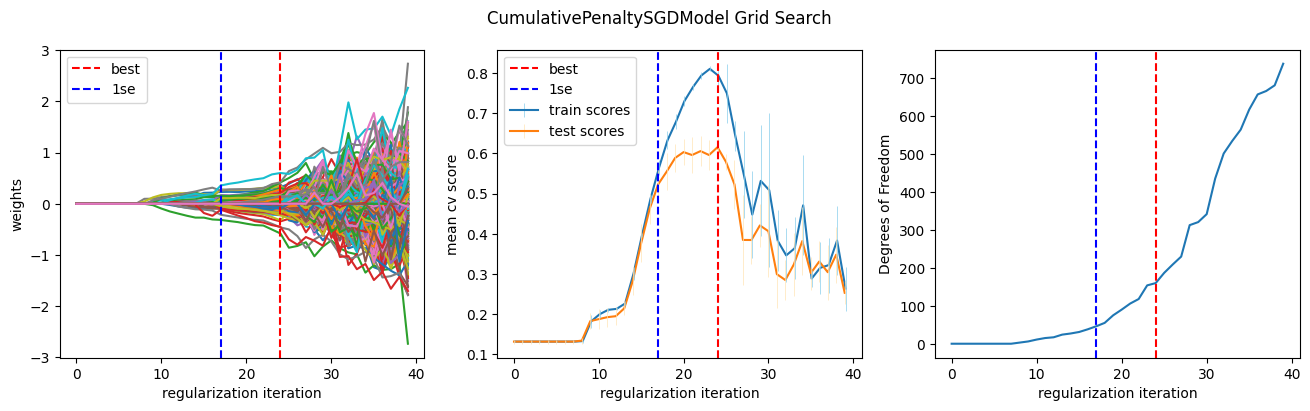

In [9]:
_ = psuper.plot_grid_search(title="CumulativePenaltySGDModel Grid Search")

Model Degrees of freedom 58
Accuracy: 0.5669099756690997
Balanced accuracy: 0.428301656920078
Mean absolute delta: 1.004706209969368


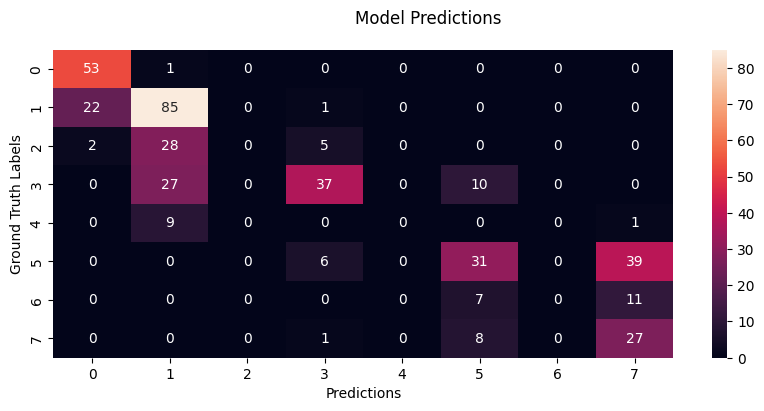

In [11]:
_ = psuper.plot_model_perf(train=(adata.X, adata.obs.ordinal_label))

**Training success and the binary training paradigm produces the exact same parameters as the multi-class wrapper, given the same data and seed.**

## Genes Python

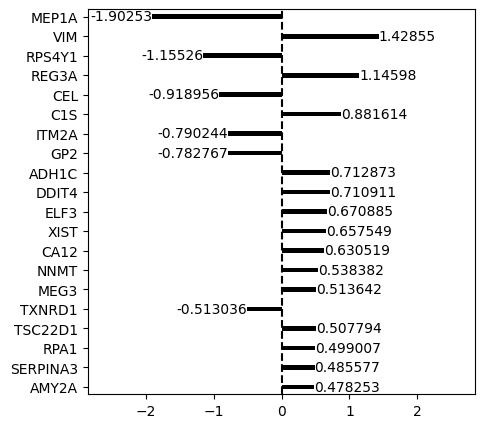

In [46]:
_ = psuper.plot_identified_gene_coefficients(adata, n_top=30, figsize=(5,5))

## R Training

![Psupertime predictions against class labels](Acinar_R_ConfusionMatrix.png)

Text(0.5, 0.98, 'Regularization Grid Search (in R)')

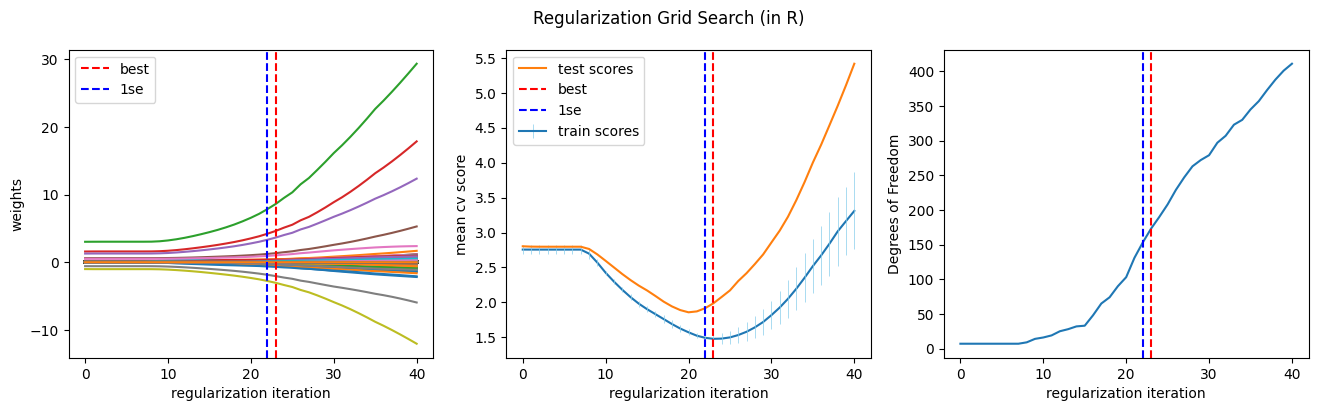

In [7]:
from matplotlib import pyplot as plt

# model weights and degrees of freedom
training_weights_r = pd.read_csv("../03_Acinar_R_analysis/weights.csv")
weights_list_r = list(training_weights_r.iloc[:,1:].to_numpy().T)
dof_r = [sum(np.array(w) != 0) for w in weights_list_r]

train_res_r = pd.read_csv("../03_Acinar_R_analysis/train_scores.csv")
test_res_r = pd.read_csv("../03_Acinar_R_analysis/test_scores.csv")


n_folds = 5
x = np.arange(len(train_res_r["lambda"].unique().flatten()))

best_idx = 23
ose_idx = 22

test_scores = test_res_r["score_val"].to_numpy()
train_scores = np.reshape(train_res_r["score_val"], (len(x), n_folds), "F")
train_means = train_scores.mean(axis=1)
train_stds = train_scores.std(axis=1)

fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(131)
ax1.plot(weights_list_r)
ax1.axvline(best_idx, ymin=0, ymax=1, color="red", label="best", ls="--")
ax1.axvline(ose_idx, ymin=0, ymax=1, color="blue", label="1se", ls="--")
ax1.set_xlabel("regularization iteration")
ax1.set_ylabel("weights")
#ax1.set_yscale("log")
ax1.legend()

ax3 = fig.add_subplot(132)
ax3.errorbar(x=x, y=train_means, yerr=train_stds, elinewidth=0.5, color="tab:blue", ecolor="skyblue", barsabove=True, label="train scores")
ax3.plot(x, test_scores, color="tab:orange", label="test scores")
ax3.axvline(best_idx, ymin=0, ymax=1, color="red", label="best", ls="--")
ax3.axvline(ose_idx, ymin=0, ymax=1, color="blue", label="1se", ls="--")
ax3.set_xlabel("regularization iteration")
ax3.set_ylabel("mean cv score")
ax3.legend()

ax2 = fig.add_subplot(133)
 
ax2.plot(dof_r)
ax2.axvline(best_idx, ymin=0, ymax=1, color="red", label="best", ls="--")
ax2.axvline(ose_idx, ymin=0, ymax=1, color="blue", label="1se", ls="--")
ax2.set_xlabel("regularization iteration")
ax2.set_ylabel("Degrees of Freedom")

fig.suptitle("Regularization Grid Search (in R)")

**Training seems plausible. Overfitting also in the original work. NOTE: As can be seen from the best and 1se index selected by (R-)psupertime, the "best score" and "next score" are determined based on the _training_ performance, not the validation split!**

## R results

```
> pobj <- psupertime::psupertime(acinar_sce,
+                                  acinar_sce$donor_age,
+                                  smooth=FALSE,
+                                  min_expression = 0.01,
+                                  scale=TRUE,
+                                  sel_genes="list",
+                                  gene_list=acinar_hvg, penalization='1se')
> paste(pobj$beta_dt[pobj$beta_dt$abs_beta != 0]$symbol, collapse="', '")
[1] "RPS4Y1', 'MEP1A', 'ADH1C', 'ITM2A', 'CA12', 'CEL', 'XIST', 'HSPH1', 'C8orf4', 'AZGP1', 'REG3A', 'CFB', 'SERPINF1', 'VIM', 'SERPINA3', 'TXNRD1', 'FBXO32', 'DDIT4', 'DNAJB4', 'SAT1', 'NBEAL1', 'PM20D1', 'SLC39A14', 'ZFAND5', 'RPL36', 'KRT7', 'SPOCK1', 'FGL1', 'TNFAIP3', 'CLDND1', 'PMPCB', 'IDI1', 'ALDH1A1', 'PSAT1', 'USP9X', 'TACSTD2', 'ENTPD3', 'AKTIP', 'PNRC2', 'GDAP1', 'CDR1', 'BTG2', 'C16orf89', 'GDF15', 'MAP1LC3B', 'NNMT', 'PNLIPRP2', 'TFPI2', 'ELF3', 'ZNF564', 'RCHY1', 'TMX2', 'MEG3', 'KBTBD7', 'XRCC6', 'CD74', 'C10orf10', 'TSC22D1', 'FSTL3', 'AMY2B', 'ATRN', 'DUSP1', 'TTN', 'ANXA2', 'TMEM70', 'KIAA1109', 'CDC23', 'CNN3', 'ANXA10', 'CLDN4', 'C6orf222', 'RPS19', 'GPX2', 'UGT2B7', 'PDK4', 'GDI2', 'SERINC1', 'HIST2H2BE', 'PGM1', 'SESN2', 'STK3', 'BPGM', 'IFIT2', 'GBE1', 'RPS6KC1', 'EXD2', 'BIRC3', 'KDELR3', 'RNF2', 'KIAA1279', 'GSTA1', 'ASUN', 'SEC16B', 'CDKN2AIP', 'BTAF1', 'ITGA6', 'KLHDC2', 'ID1', 'NFKBIZ', 'CYR61', 'ANXA5', 'DAZAP2', 'FASTKD2', 'C5orf51', 'SGK1', 'OXSM', 'MAOA', 'GLUL', 'THBS1', 'REG1P', 'VCAM1', 'C1S', 'SCCPDH', 'MAT2A', 'FAM217B', 'ZNF192', 'STAT1', 'CCBL2', 'NFYA', 'TCN1', 'MED20', 'ALG9', 'IVNS1ABP', 'HEXB', 'ALDH9A1', 'CEACAM6', 'CSF3', 'UAP1', 'HILPDA', 'DHRS2', 'C5orf28', 'HELQ', 'FAM120B', 'IST1', 'PAM', 'RYR2', 'ASNS', 'KIAA1033', 'MTERFD3', 'MTAP', 'TTLL5', 'DNAH7', 'ALB', 'PIGW', 'DIRAS3', 'C15orf48"
> balanced_accuracy(as.integer(pobj$proj_dt$label_input), as.integer(pobj$proj_dt$label_psuper))
[1] 0.5649795
> accuracy(as.integer(pobj$proj_dt$label_input), as.integer(pobj$proj_dt$label_psuper))
[1] 0.7810219
> mean_abs_error(as.integer(pobj$proj_dt$label_input), as.integer(pobj$proj_dt$label_psuper))
[1] 0.2822384
> pobj$best_dt
     score_var best_lambda next_lambda best_idx next_idx
1: class_error 0.006309573 0.012589254       23       20
2:    xentropy 0.005011872 0.006309573       24       23
> pobj
psupertime object using 411 cells * 23368 genes as input
    label ordering used for training: 1, 5, 6, 21, 22, 38, 44, 54
    genes selected for input: list
    # genes taken forward for training: 822
    # genes identified as relevant: 146 (= 18% of training genes)
    mean training accuracy: 66%
    mean test accuracy: 59%
```

Does R evaluate on Train data during cv??

## Extract Genes

In [12]:
adata.var.psupertime_weight

REG3A       0.174033
AMY2A       0.000000
OLFM4       0.000000
MT2A        0.000000
FGL1        0.019532
              ...   
HLA-DPA1    0.000000
MMAA        0.000000
ANTXR2      0.000000
ZNF586      0.000000
ULBP2       0.000000
Name: psupertime_weight, Length: 827, dtype: float32

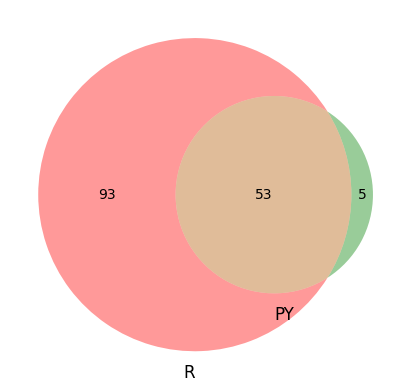

In [14]:
genes_py = adata.var_names[adata.var.psupertime_weight != 0]
genes_r = ['RPS4Y1', 'MEP1A', 'ADH1C', 'ITM2A', 'CA12', 'CEL', 'XIST',
           'HSPH1', 'C8orf4', 'AZGP1', 'REG3A', 'CFB', 'SERPINF1', 'VIM',
           'SERPINA3', 'TXNRD1', 'FBXO32', 'DDIT4', 'DNAJB4', 'SAT1',
           'NBEAL1', 'PM20D1', 'SLC39A14', 'ZFAND5', 'RPL36', 'KRT7',
           'SPOCK1', 'FGL1', 'TNFAIP3', 'CLDND1', 'PMPCB', 'IDI1', 'ALDH1A1',
           'PSAT1', 'USP9X', 'TACSTD2', 'ENTPD3', 'AKTIP', 'PNRC2', 'GDAP1',
           'CDR1', 'BTG2', 'C16orf89', 'GDF15', 'MAP1LC3B', 'NNMT', 'PNLIPRP2',
           'TFPI2', 'ELF3', 'ZNF564', 'RCHY1', 'TMX2', 'MEG3', 'KBTBD7',
           'XRCC6', 'CD74', 'C10orf10', 'TSC22D1', 'FSTL3', 'AMY2B', 'ATRN',
           'DUSP1', 'TTN', 'ANXA2', 'TMEM70', 'KIAA1109', 'CDC23', 'CNN3',
           'ANXA10', 'CLDN4', 'C6orf222', 'RPS19', 'GPX2', 'UGT2B7', 'PDK4',
           'GDI2', 'SERINC1', 'HIST2H2BE', 'PGM1', 'SESN2', 'STK3', 'BPGM',
           'IFIT2', 'GBE1', 'RPS6KC1', 'EXD2', 'BIRC3', 'KDELR3', 'RNF2',
           'KIAA1279', 'GSTA1', 'ASUN', 'SEC16B', 'CDKN2AIP', 'BTAF1',
           'ITGA6', 'KLHDC2', 'ID1', 'NFKBIZ', 'CYR61', 'ANXA5', 'DAZAP2',
           'FASTKD2', 'C5orf51', 'SGK1', 'OXSM', 'MAOA', 'GLUL', 'THBS1',
           'REG1P', 'VCAM1', 'C1S', 'SCCPDH', 'MAT2A', 'FAM217B', 'ZNF192',
           'STAT1', 'CCBL2', 'NFYA', 'TCN1', 'MED20', 'ALG9', 'IVNS1ABP',
           'HEXB', 'ALDH9A1', 'CEACAM6', 'CSF3', 'UAP1', 'HILPDA', 'DHRS2',
           'C5orf28', 'HELQ', 'FAM120B', 'IST1', 'PAM', 'RYR2', 'ASNS',
           'KIAA1033', 'MTERFD3', 'MTAP', 'TTLL5', 'DNAH7', 'ALB', 'PIGW',
           'DIRAS3', 'C15orf48']

from matplotlib_venn import venn2, venn2_circles
venn2([set(genes_r), set(genes_py)], set_labels=("R", "PY"))

## Compare based on Clustermap

In [15]:
import scanpy as sc
import os

# Union and intersect of the identified genes
union = list(set(genes_py).union(set(genes_r)))
intersect = list(set(genes_py).intersection(set(genes_r)))

filename = "/home/julian/Uni/MasterThesis/data/acinar_sce.h5ad"
acinar_raw = sc.read_h5ad(filename)

counts = acinar_raw[:,union].copy()

# Add a column indicating from which tool a gene was called
counts.var["group"] = None
counts.var.loc[genes_py, "group"] = "PY"
counts.var.loc[genes_r, "group"] = "R"
counts.var.loc[intersect, "group"] = "PY,R"

/home/julian/.local/share/virtualenvs/code-tW9RC7Ez/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


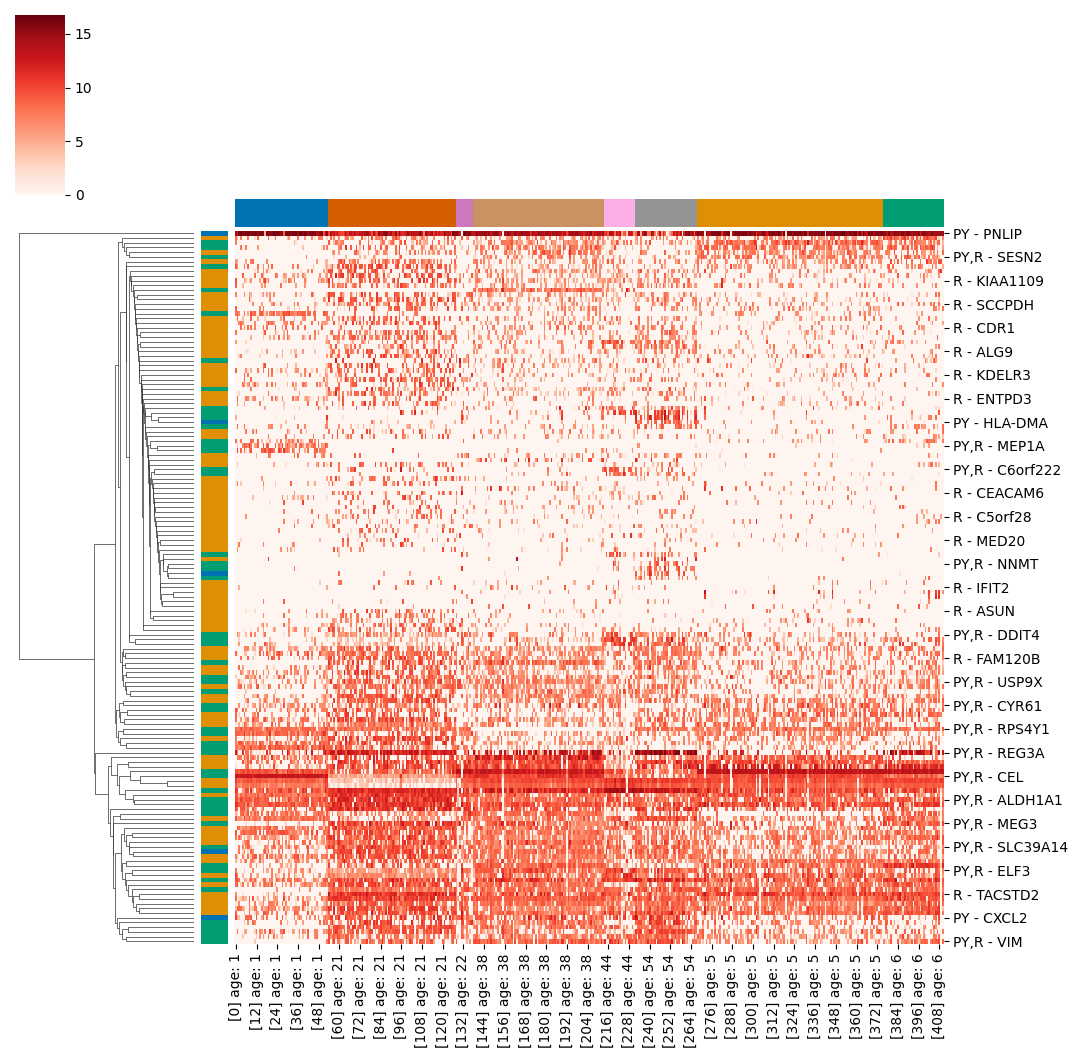

In [18]:
from pypsupertime.preprocessing import transform_labels
from scipy.spatial import distance
from scipy.cluster import hierarchy
import seaborn as sns

# color palette
cmap_seq = sns.color_palette("Reds", as_cmap=True)

col_labels = transform_labels(counts.obs.donor_age.to_numpy())
cmap = sns.color_palette("colorblind", max(3, len(np.unique(col_labels))))

# row and column colors based on group and ordinal cell label
col_colors = [cmap[int(e)] for e in col_labels]
row_colors = [cmap[0 if e == "PY" else 1 if e == "R" else 2] for e in counts.var["group"].to_numpy()]

g = sns.clustermap(counts.X.T, cmap=cmap_seq, col_cluster=False, col_colors=col_colors, row_colors=row_colors)
ordering = g.dendrogram_row.reordered_ind

ylabels = []
# iterate only over the ticks that are plotted!
for text in g.ax_heatmap.get_yticklabels():
    # the Text() object contains the row index as a string
    i = int(text.get_text())
    group = counts.var.iloc[i].group
    gene_name = counts.var.iloc[i].name
    label = "%s - %s" % (group, gene_name)
    ylabels.append(label)
g.ax_heatmap.set_yticklabels(ylabels, rotation=0)

xlabels = []
# iterate only over the ticks that are plotted!
for text in g.ax_heatmap.get_xticklabels():
    # the Text() object contains the row index as a string
    i = int(text.get_text())
    time_label = counts.obs.iloc[i].donor_age
    label = "[%s] age: %s" % (i, time_label)
    xlabels.append(label)
g.ax_heatmap.set_xticklabels(xlabels, rotation=90)

# Display the plot
plt.show()

In [19]:
cmap_diverging = sns.diverging_palette(220, 20, as_cmap=True, center="light")

/home/julian/.local/share/virtualenvs/code-tW9RC7Ez/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/julian/.local/share/virtualenvs/code-tW9RC7Ez/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


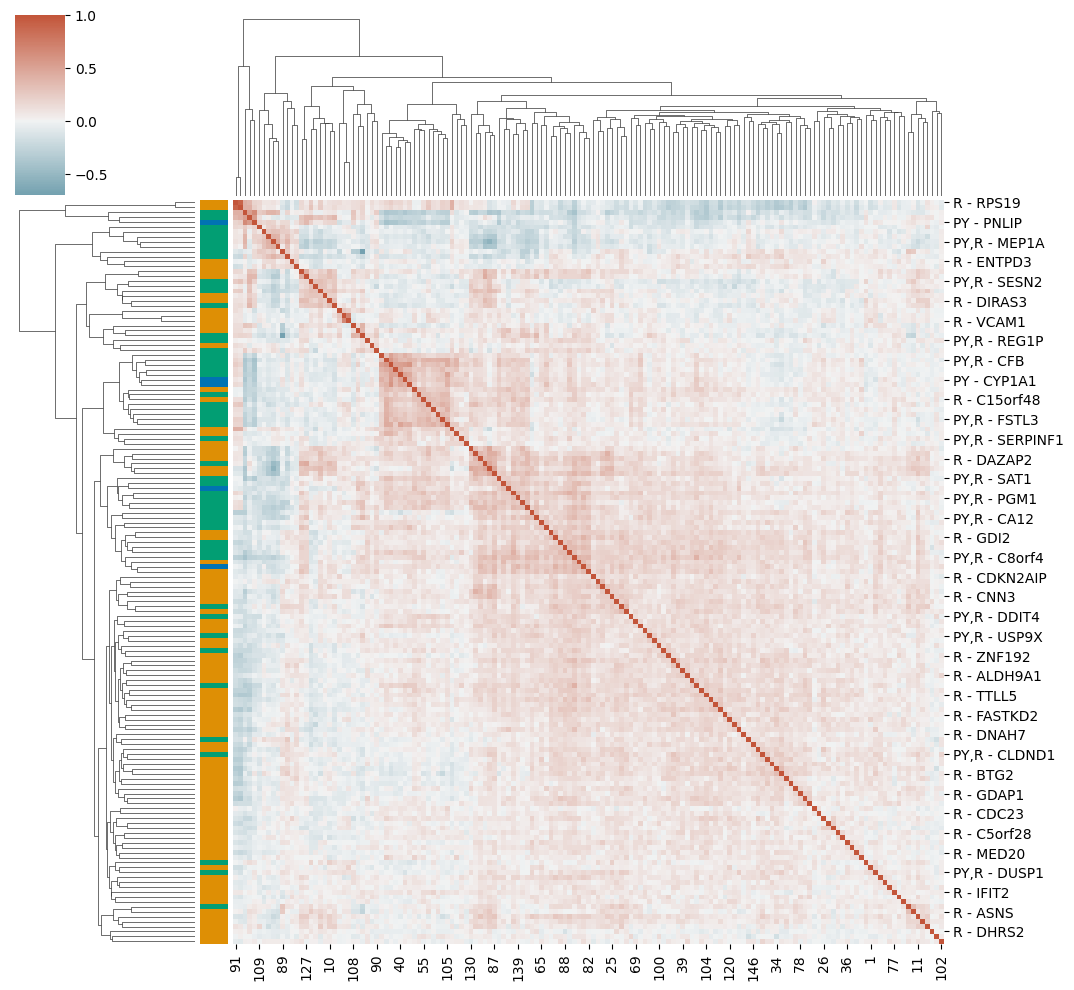

In [20]:
g = sns.clustermap(np.corrcoef(counts.X.T), center=0.0, cmap=cmap_diverging, col_cluster=True, row_colors=row_colors)

ylabels = []
# iterate only over the ticks that are plotted!
for text in g.ax_heatmap.get_yticklabels():
    # the Text() object contains the row index as a string
    i = int(text.get_text())
    group = counts.var.iloc[i].group
    gene_name = counts.var.iloc[i].name
    label = "%s - %s" % (group, gene_name)
    ylabels.append(label)
_ = g.ax_heatmap.set_yticklabels(ylabels, rotation=0)

## Compare to hierarchical clusters

In [22]:
import scanpy as sc
sc.tl.pca(adata, n_comps=4)

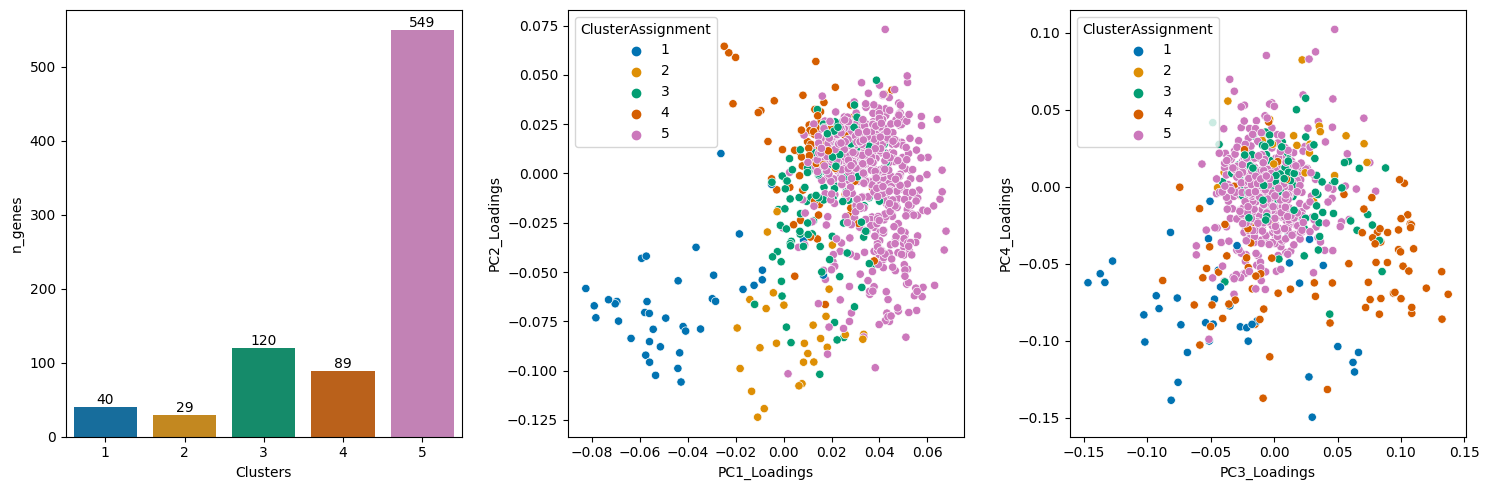

In [23]:
from scipy.cluster.hierarchy import linkage, fcluster

# calculate complete linkage on gene level
gene_linkage = linkage(adata.X.T, method="complete")

n_clusters = 5
flat_cluster_assignment = fcluster(gene_linkage, t=n_clusters, criterion="maxclust")

d = pd.DataFrame.from_dict({
        "PC1_Loadings": adata.varm["PCs"][:,0], 
        "PC2_Loadings": adata.varm["PCs"][:,1],
        "PC3_Loadings": adata.varm["PCs"][:,2], 
        "PC4_Loadings": adata.varm["PCs"][:,3],
        "ClusterAssignment": flat_cluster_assignment
    })

uq, cts = np.unique(flat_cluster_assignment, return_counts=True)
d2 = pd.DataFrame.from_dict({
        "Clusters": uq,
        "n_genes": cts
})

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5), sharex=False, sharey=False)

palette = cmap[:len(uq)]
sns.barplot(d2, x="Clusters", y="n_genes", ax=ax1, palette=palette)
ax1.bar_label(ax1.containers[0])
sns.scatterplot(d, x="PC1_Loadings", y="PC2_Loadings", hue="ClusterAssignment", ax=ax2, palette=palette)
sns.scatterplot(d, x="PC3_Loadings", y="PC4_Loadings", hue="ClusterAssignment", ax=ax3, palette=palette)

plt.tight_layout()

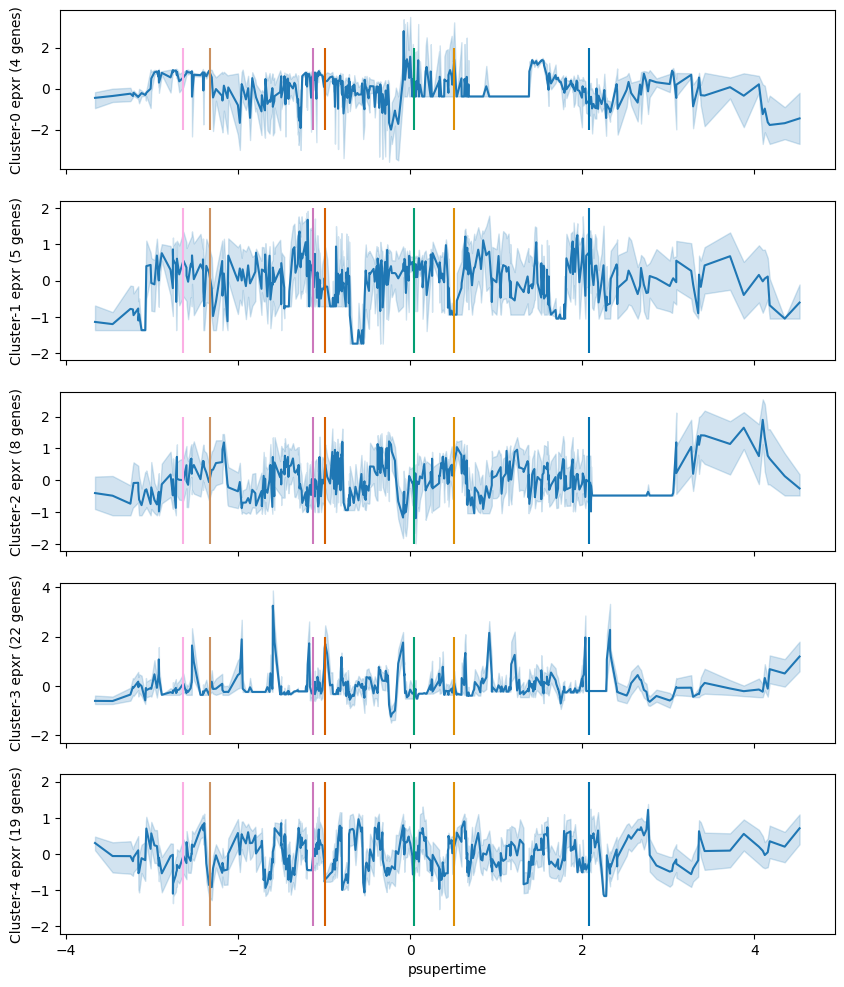

In [28]:
# calculate psupertime

genes_in_cluster = [list(adata.var.index[flat_cluster_assignment == c]) for c in uq]

# plot the expression for each cluster over psupertime
fig, axes = plt.subplots(nrows=n_clusters, ncols=1, sharex=True, sharey=False, figsize=(10, 12))
idx_sorted = np.argsort(adata.obs.psupertime.to_numpy())

for i in range(n_clusters):
    _genes = list(set(genes_py).intersection(set(genes_in_cluster[i]))) # genes_in_cluster[i] #
    d = pd.DataFrame(adata[:, _genes].X[idx_sorted,:], columns=_genes)
    d = d.melt(var_name="Gene", value_name="normalized_expression")
    d["psupertime"] = adata.obs["psupertime"][idx_sorted].repeat(len(_genes)).to_numpy()
    d["Cluster"] = i

    ax = axes[i]
    #sns.lineplot(d, x="psupertime", y="normalized_expression", ax=ax)
    sns.lineplot(d, x="psupertime", y="normalized_expression", ax=ax)
    #sns.lmplot(d, x="psupertime", y="normalized_expression", lowess=True)
    
    ax.vlines(psuper.model.intercept_,
              ymin=-2,#ymin=np.min(d["normalized_expression"]),
              ymax=2,#ymax=np.max(d["normalized_expression"]),
              colors=cmap)
    
    #ax.set_xlim((-50, 30))
    ax.set_ylabel("Cluster-%s epxr (%s genes)" % (i, len(_genes)))

**Cell orderings bad?**

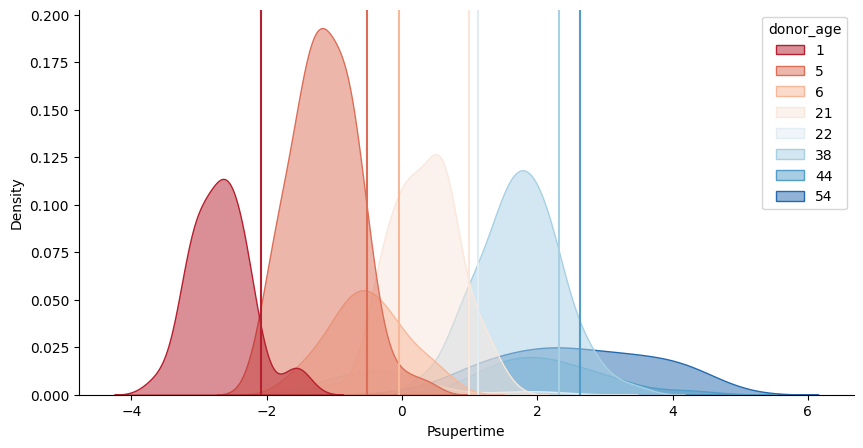

In [29]:
_ = psuper.plot_labels_over_psupertime(adata, "donor_age")

## Inspect Clustered Gene Expression

**TODO/Issue: Not the PCA Clusters but PCA _Loadings_ are considered below! Do again with PCA on gene dimension.**

In [30]:
background_genes_key = "unselected"
adata.var["group"] = counts.var.group
adata.var.group = adata.var.group.fillna(background_genes_key)

In [31]:
# Calculate PCA embedding with scanpy
#import scanpy as sc
#sc.tl.pca(acinar_sce, n_comps=4)
# -> only does PCA on cells and reports gene loadings

# Calculate PCA with sklearn -> uses second dimension by default
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(adata.X)
pca.components_.shape

(4, 827)

Text(0.5, 0, 'Principle Component')

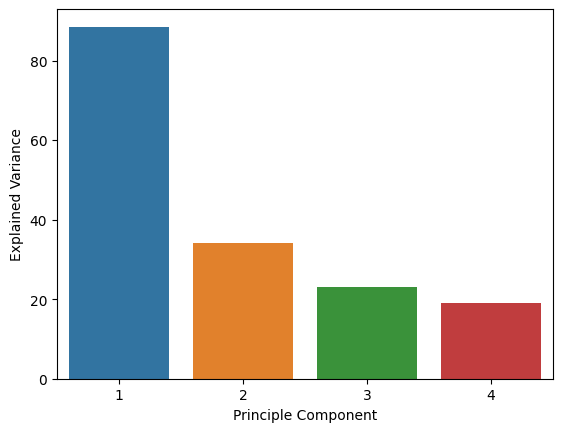

In [32]:
d = pd.DataFrame.from_dict({
        "Explained_Variance": pca.explained_variance_,
        "Principal_Component": np.arange(1, pca.n_components_ + 1)
    })

ax = sns.barplot(data=d, x="Principal_Component", y="Explained_Variance")
ax.set_ylabel("Explained Variance")
ax.set_xlabel("Principle Component")

Text(0.5, 0, 'PC3 (23.00 %)')

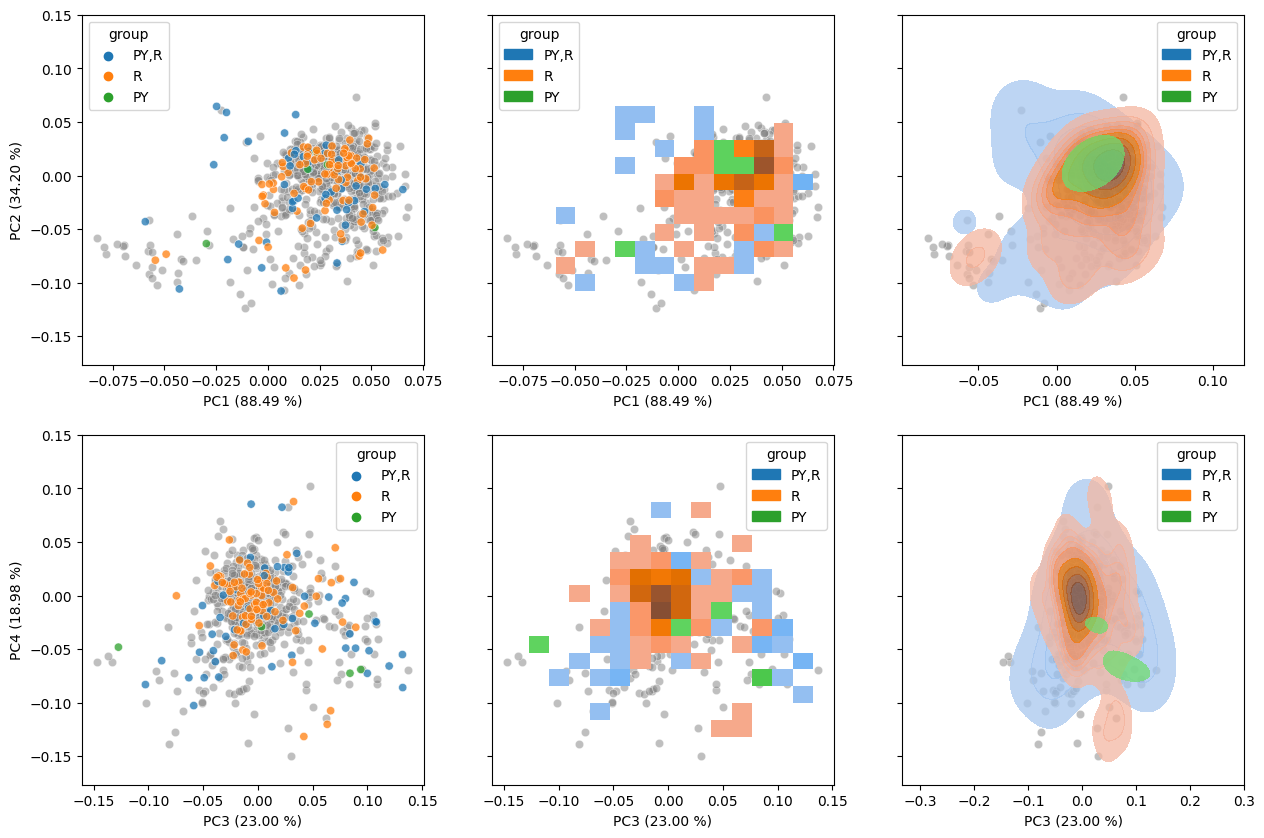

In [33]:
d = pd.DataFrame.from_dict({
    "PC1": pca.components_[0], 
    "PC2": pca.components_[1],
    "PC3": pca.components_[2], 
    "PC4": pca.components_[3],
    "group": adata.var.group
})


fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, ncols=3, figsize=(15, 10), sharex=False, sharey=True)
# plot the background points first
sns.scatterplot(d[d["group"] == background_genes_key], x="PC1", y="PC2", ax=ax1, alpha=0.5, color="grey")
sns.scatterplot(d[d["group"] != background_genes_key], x="PC1", y="PC2", hue="group",  ax=ax1, alpha=0.75)
ax1.set_xlabel("PC1 (%.2f %%)" % (pca.explained_variance_[0]))
ax1.set_ylabel("PC2 (%.2f %%)" % (pca.explained_variance_[1]))

# plot the background points first
sns.scatterplot(d[d["group"] == background_genes_key], x="PC1", y="PC2", ax=ax2, alpha=0.5, color="grey")
sns.histplot(d[d["group"] != background_genes_key], x="PC1", y="PC2", hue="group", ax=ax2)
ax2.set_xlabel("PC1 (%.2f %%)" % (pca.explained_variance_[0]))

# plot the background points first
sns.scatterplot(d[d["group"] == background_genes_key], x="PC1", y="PC2", ax=ax3, alpha=0.5, color="grey")
sns.kdeplot(d[d["group"] != background_genes_key], x="PC1", y="PC2", hue="group", ax=ax3, fill=True, alpha=0.75)
ax3.set_xlabel("PC1 (%.2f %%)" % (pca.explained_variance_[0]))

# plot the background points first
sns.scatterplot(d[d["group"] == background_genes_key], x="PC3", y="PC4", ax=ax4, alpha=0.5, color="grey")
sns.scatterplot(d[d["group"] != background_genes_key], x="PC3", y="PC4", hue="group",  ax=ax4, alpha=0.75)
ax4.set_xlabel("PC3 (%.2f %%)" % (pca.explained_variance_[2]))
ax4.set_ylabel("PC4 (%.2f %%)" % (pca.explained_variance_[3]))

# plot the background points first
sns.scatterplot(d[d["group"] == background_genes_key], x="PC3", y="PC4", ax=ax5, alpha=0.5, color="grey")
sns.histplot(d[d["group"] != background_genes_key], x="PC3", y="PC4", hue="group", ax=ax5)
ax5.set_xlabel("PC3 (%.2f %%)" % (pca.explained_variance_[2]))

# plot the background points first
sns.scatterplot(d[d["group"] == background_genes_key], x="PC3", y="PC4", ax=ax6, alpha=0.5, color="grey")
sns.kdeplot(d[d["group"] != background_genes_key], x="PC3", y="PC4", hue="group", ax=ax6, fill=True, alpha=0.75)
ax6.set_xlabel("PC3 (%.2f %%)" % (pca.explained_variance_[2]))


## GO Analysis

In [65]:
# GO ANALYSIS Run using panther: http://pantherdb.org/
# - Statistical Overrepresentation Test
# - Fishers Exact Test
# - Bonferroni Correction to read Bonferroni Count
# - Export table with no correction

In [64]:
# write two gene lists:
with open("go-genelist-py-5.csv", "w") as py_genes_file:
    py_genes_file.write("\n".join(genes_py))
    
with open("go-genelist-r.csv", "w") as r_genes_file:
    r_genes_file.write("\n".join(genes_r))

with open("go-referencelist-hvg.csv", "w") as ref:
    ref.write("\n".join(acinar_hvg))
    
with open("go-referencelist-acinargenes.csv", "w") as ref:
    ref.write("\n".join(acinar_sce.var_names))

### HVG Reference

In [85]:
go_results = pd.read_csv("go_results_vs_hvg_5.txt", sep="\t", skiprows=11)
go_results.columns

Index(['GO biological process complete',
       'go-referencelist-hvg.csv - REFLIST (815)',
       'go-genelist-py-5.csv (113)', 'go-genelist-py-5.csv (expected)',
       'go-genelist-py-5.csv (over/under)',
       'go-genelist-py-5.csv (fold Enrichment)',
       'go-genelist-py-5.csv (raw P-value)', 'go-genelist-r.csv (142)',
       'go-genelist-r.csv (expected)', 'go-genelist-r.csv (over/under)',
       'go-genelist-r.csv (fold Enrichment)',
       'go-genelist-r.csv (raw P-value)'],
      dtype='object')

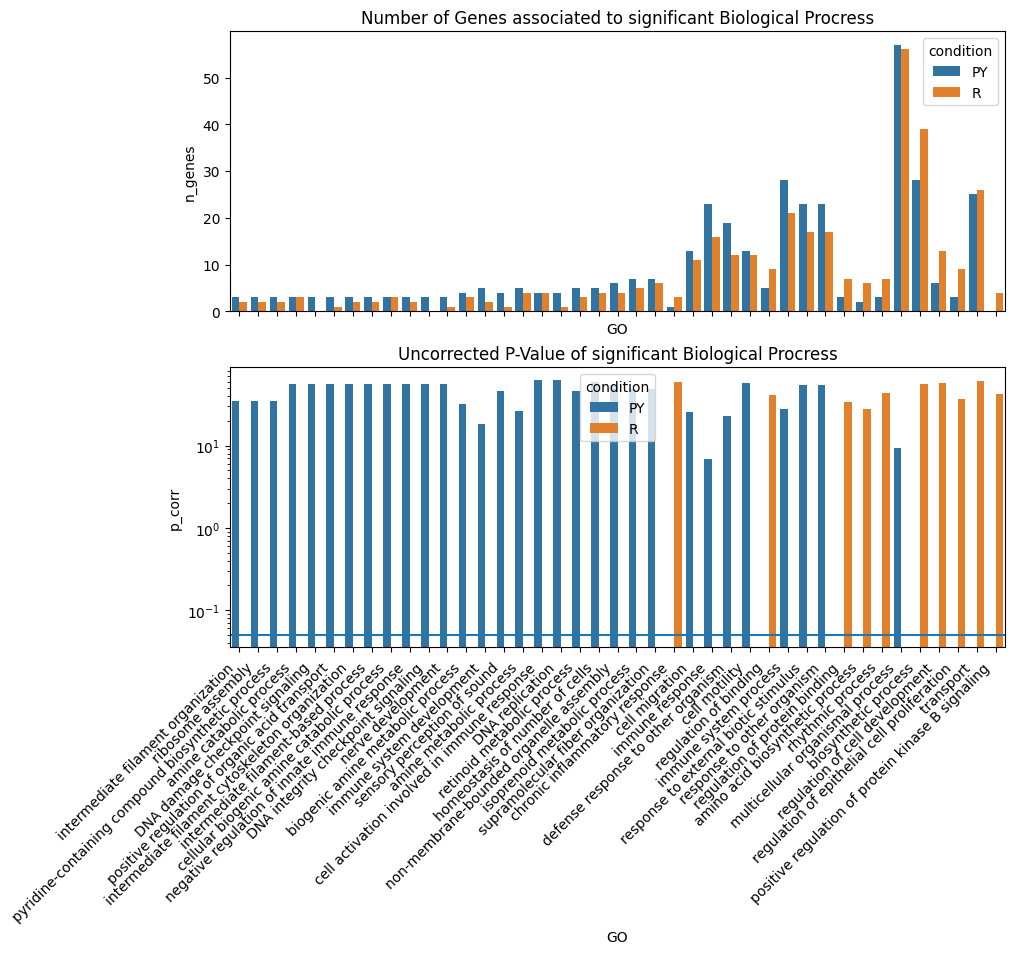

In [90]:
d = pd.DataFrame.from_dict({
    "GO": go_results.iloc[:, 0].str[:-12].to_numpy().repeat(2),
    "n_genes": np.column_stack([go_results.iloc[:, 2], go_results.iloc[:,7]]).flatten(),
    "expected": go_results.iloc[:,go_results.columns.str.contains("expected")].to_numpy().flatten(),
    "fold_enrichment": go_results.iloc[:,go_results.columns.str.contains("fold Enrichment")].to_numpy().flatten(),
    "over/under": go_results.iloc[:,go_results.columns.str.contains("over/under")].to_numpy().flatten(),
    "p_raw": go_results.iloc[:,go_results.columns.str.contains("raw P-value")].to_numpy().flatten(),
    "condition": ["PY", "R"] * go_results.shape[0]
})

bonferroni_count = 1319
d["p_corr"] = d["p_raw"] * bonferroni_count
# -> No corrected hits

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(10, 8))

sub = d[(d["p_raw"] < 0.05)]
_ = sns.barplot(sub, x="GO", y="p_corr", hue="condition", orient="v", ax=ax2)
_ = ax2.set_xticklabels(sub.GO.unique(), rotation=45, ha="right")
_ = ax2.set_yscale("log")
_ = ax2.set_title("Uncorrected P-Value of significant Biological Procress")
_ = ax2.axhline(0.05)

sub2 = d.loc[d.GO.isin(sub.GO)]
_ = sns.barplot(sub2, x="GO", y="n_genes", hue="condition", ax=ax1)
_ = ax1.set_xticklabels(sub2.GO.unique(), rotation=45, ha="right")
_ = ax1.set_title("Number of Genes associated to significant Biological Procress")


### Human Genes Reference

In [83]:
go_results = pd.read_csv("go_results_vs_human_5.txt", sep="\t", skiprows=11)
d = pd.DataFrame.from_dict({
    "GO": go_results.iloc[:, 0].str[:-12].to_numpy().repeat(2),
    "n_genes": np.column_stack([go_results.iloc[:, 2], go_results.iloc[:,7]]).flatten(),
    "expected": go_results.iloc[:,go_results.columns.str.contains("expected")].to_numpy().flatten(),
    "fold_enrichment": go_results.iloc[:,go_results.columns.str.contains("fold Enrichment")].to_numpy().flatten(),
    "over/under": go_results.iloc[:,go_results.columns.str.contains("over/under")].to_numpy().flatten(),
    "p_raw": go_results.iloc[:,go_results.columns.str.contains("P-value")].to_numpy().flatten(),
    "condition": ["PY", "R"] * go_results.shape[0]
})

# Bonferroni Correction
bonferroni_count = 9260
d["p_corr"] = d["p_raw"] * bonferroni_count

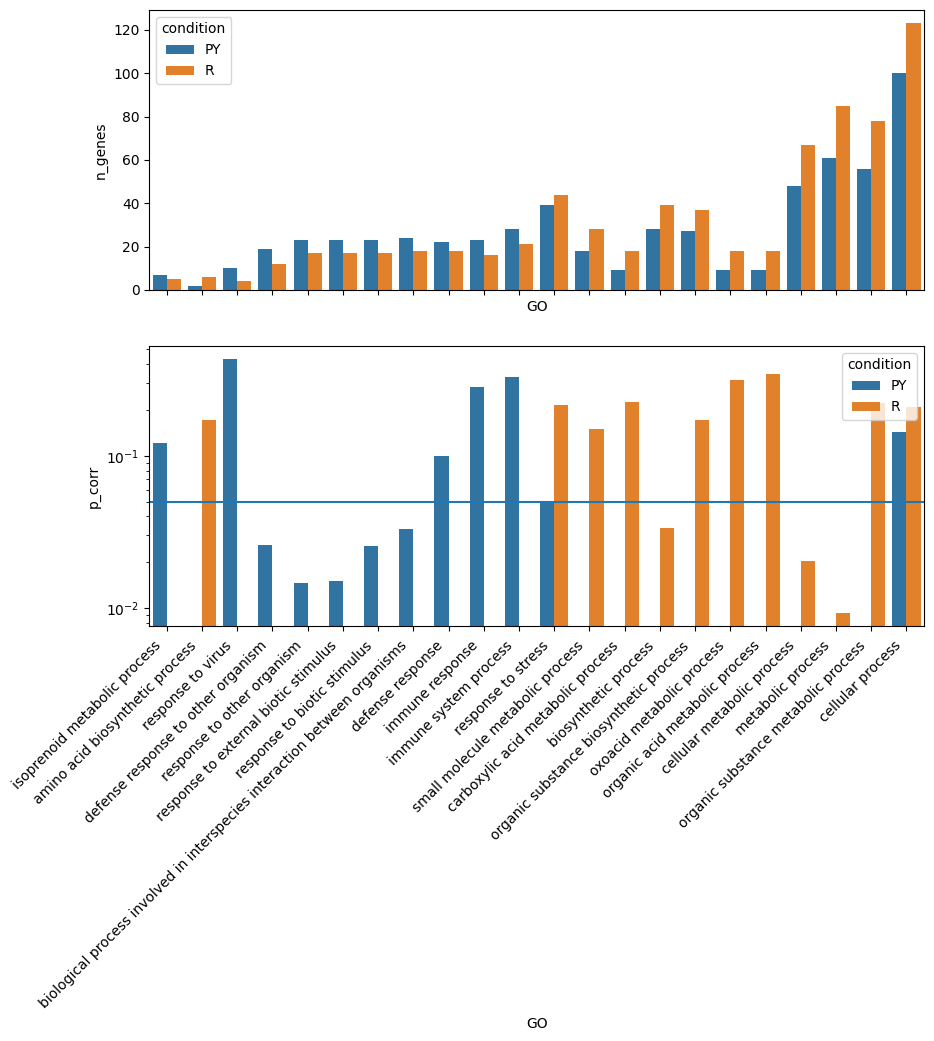

In [84]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

sub = d.loc[(d["p_corr"] < 0.5)]
_ = sns.barplot(sub, x="GO", y="p_corr", hue="condition", orient="v", ax=ax2)
_ = ax2.set_xticklabels(sub.GO.unique(), rotation=45, ha="right")
_ = ax2.set_yscale("log")
_ = ax2.axhline(0.05)

sub2 = d.loc[d.GO.isin(sub.GO)]
_ = sns.barplot(sub2, x="GO", y="n_genes", hue="condition", ax=ax1)
_ = ax1.set_xticklabels(sub2.GO.unique(), rotation=45, ha="right")

### By Cluster

In [669]:
for i, c in enumerate(genes_in_cluster):
    _genes = set(genes_py).intersection(set(c))
    with open("go-genelist-py-cluster-%s.csv" % i, "w") as py_genes_file:
        py_genes_file.write("\n".join(_genes))
    
    _genes = set(genes_r).intersection(set(c))
    with open("go-genelist-r-cluster-%s.csv" % i, "w") as r_genes_file:
        r_genes_file.write("\n".join(genes_r))
        
    _genes = []    
    for j, c2 in enumerate(genes_in_cluster):
        if j==i:
            continue
        else:
            _genes += c2
    
    with open("go-genelist-rest-%s.csv" % i, "w") as rest_file:
        r_genes_file.write("\n".join(genes_r))